In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from types import SimpleNamespace
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, psiam_tied_data_gen_wrapper_rate_norm_fn

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# exp fixation

In [3]:
V_A = 1.596
theta_A = 2.531
t_A_aff = -0.226
del_go = 0.13

In [4]:
rate_lambda  = 0.13
T_0    = 0.45 * 1e-3
theta_E       = 45 
Z_E           = 0
t_E_aff       = 68 * 1e-3
rate_norm_l   = 0
bump_height = 0.35843
bump_width = 0.28042
dip_height = 0.29913
dip_width = 0.01818
bump_offset = 0

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [5]:
N_sim = int(1e6)
t_stim_samples_exp_fix = np.random.exponential(scale=0.4, size=N_sim) + 0.2
ABL_samples = df['ABL'].sample(N_sim, replace=True).values
ILD_samples = df['ILD'].sample(N_sim, replace=True).values


N_print = int(N_sim / 5)
dt  = 1e-4

##### time varying evidence ##########
sim_results_exp_fix = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples_exp_fix[iter_num], rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)


######### constant evidence ###########
# sim_results_exp_fix = Parallel(n_jobs=30)(
#     delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
#         V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
#         t_stim_samples_exp_fix[iter_num], rate_norm_l, iter_num, N_print, dt
#     ) for iter_num in tqdm(range(N_sim))
# )

  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 1409990, In iter_num: 0, ABL: 40, ILD: -16.0, t_stim: 0.4457569064848441
os id: 1409994, In iter_num: 200000, ABL: 40, ILD: -1.0, t_stim: 1.023215142373196
os id: 1410050, In iter_num: 400000, ABL: 20, ILD: -4.0, t_stim: 0.8973558059380657
os id: 1410037, In iter_num: 600000, ABL: 20, ILD: 1.0, t_stim: 0.5965256533393593
os id: 1410047, In iter_num: 800000, ABL: 60, ILD: 16.0, t_stim: 0.397854459074855


# uniform fix

In [ ]:
t_stim_samples_unif_fix = np.random.uniform(0.300, 0.350, N_sim)

###### const evidence #########
# sim_results_unif_fix = Parallel(n_jobs=30)(
#     delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
#         V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
#         t_stim_samples_unif_fix[iter_num], rate_norm_l, iter_num, N_print, dt
#     ) for iter_num in tqdm(range(N_sim))
# )

V_A_1 = 2 * V_A

#### time varying evid #########
sim_results_unif_fix = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A_1, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples_unif_fix[iter_num], rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)


# compare uniform fix and exp fix

In [7]:
exp_fix_df = pd.DataFrame(sim_results_exp_fix)
unif_fix_df = pd.DataFrame(sim_results_unif_fix)

exp_fix_rt = exp_fix_df['rt'] - exp_fix_df['t_stim']
unif_fix_rt = unif_fix_df['rt'] - unif_fix_df['t_stim']

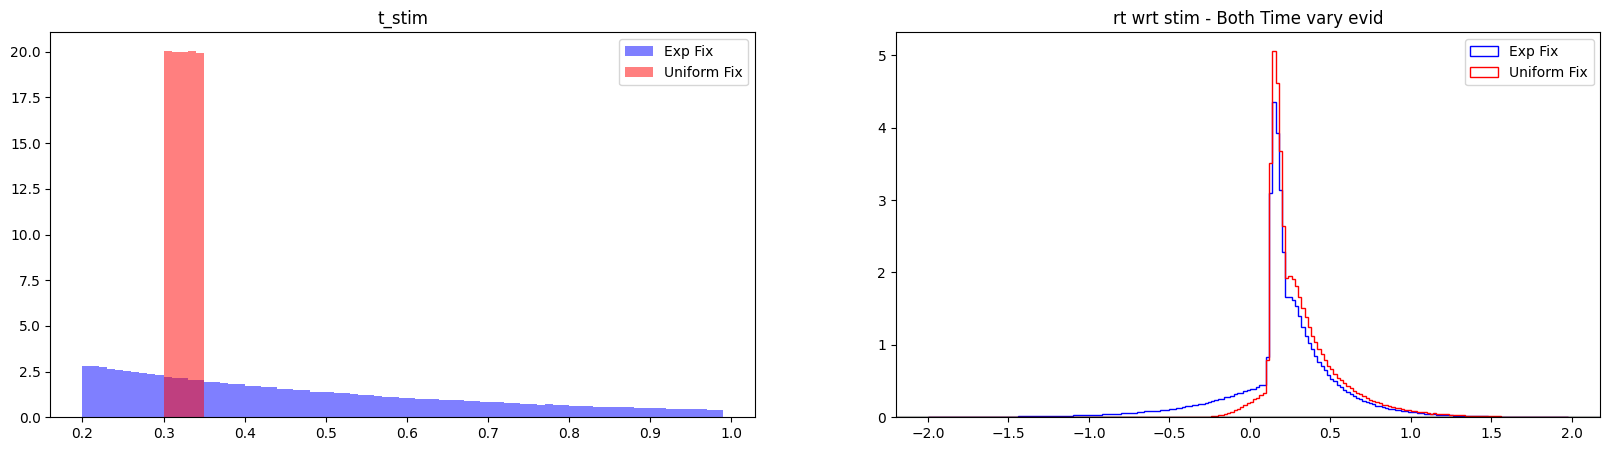

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
t_stim_bins = np.arange(0.2, 1, 0.01)
plt.hist(t_stim_samples_exp_fix, bins=t_stim_bins, alpha=0.5, label='Exp Fix', color='b', density=True)
plt.hist(t_stim_samples_unif_fix, bins=t_stim_bins, alpha=0.5, label='Uniform Fix', color='r', density=True)
plt.legend();
plt.title('t_stim')

plt.subplot(1,2,2)
bins = np.arange(-2, 2, 0.02)
plt.hist(exp_fix_rt, label='Exp Fix', color='b', density=True, histtype='step', bins=bins)
plt.hist(unif_fix_rt, label='Uniform Fix', color='r', density=True, histtype='step', bins=bins)
plt.axhline(0, color='k', alpha=0.3)
plt.legend();
plt.title('rt wrt stim - Both Time vary evid')
plt.show()



# V_A vs shape of RTD

In [46]:
from time_vary_norm_utils import rho_A_t_VEC_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz

In [65]:
rate_lambda  = 0.13
T_0    = 0.45 * 1e-3
theta_E       = 45 
Z_E           = 0
t_E_aff       = 68 * 1e-3
rate_norm_l   = 0
bump_height = 0.35843
bump_width = 0.28042
dip_height = 0.29913
# dip_height = 0.01
dip_width = 0.01818
bump_offset = 0

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

/tmp/ipykernel_1409936/2241394556.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')


Simulating for V_A=1.596:   0%|          | 0/100000 [00:00<?, ?it/s]

os id: 1417247, In iter_num: 0, ABL: 40, ILD: -16.0, t_stim: 0.33069326407102434


Simulating for V_A=3.192:   0%|          | 0/100000 [00:00<?, ?it/s]

os id: 1417269, In iter_num: 0, ABL: 40, ILD: -16.0, t_stim: 0.33069326407102434


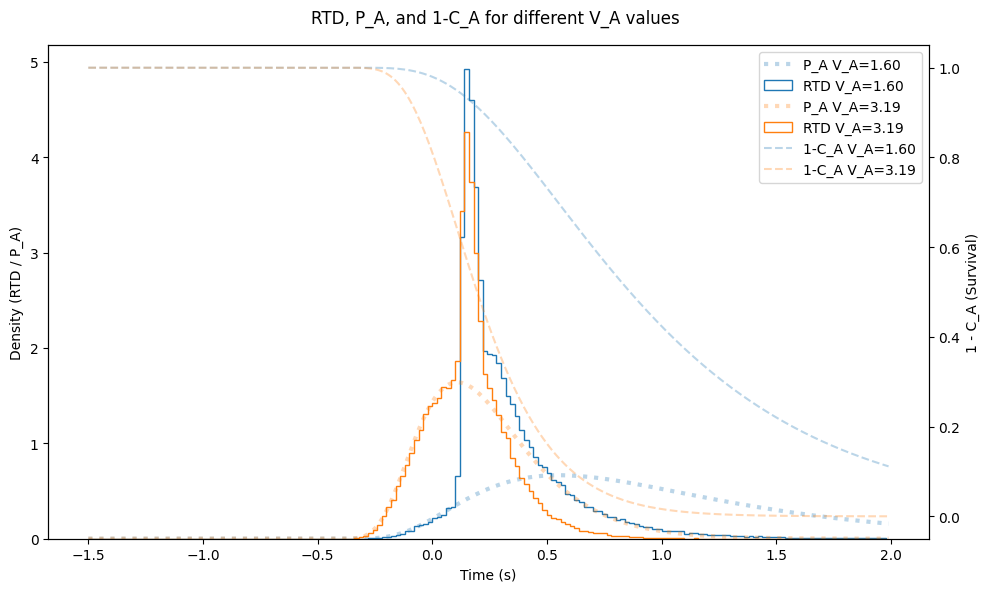

In [66]:
N_sim = int(1e5)
dt = 1e-3
V_A_samples = [V_A, 2 * V_A]

bins = np.arange(-1.5, 2, 0.02)
t_pts = np.arange(-1.5, 2, 0.01)

N_theory = int(5e3)
t_stim_distr_for_sim = np.random.uniform(0.300, 0.350, N_sim)
t_stim_distr_for_theory = np.random.uniform(0.300, 0.350, N_theory)

# For consistent colors
color_map = plt.cm.get_cmap('tab10')

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Secondary y-axis

for idx_va, V_A_sample in enumerate(V_A_samples):
    color = color_map(idx_va)

    # Theoretical part (P_A and C_A)
    P_A_samples = np.zeros((N_theory, len(t_pts)))
    for idx, t_stim in enumerate(t_stim_distr_for_theory):
        P_A_samples[idx, :] = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A_sample, theta_A)

    P_A_mean = np.mean(P_A_samples, axis=0)
    C_A_mean_survive = 1 - cumtrapz(P_A_mean, t_pts, initial=0)

    # Simulations
    sim_results = Parallel(n_jobs=30)(
        delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
            V_A_sample, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E,
            t_A_aff, t_E_aff, del_go, t_stim_distr_for_sim[iter_num], rate_norm_l, iter_num, N_print, 
            phi_params_obj, dt
        ) for iter_num in tqdm(range(N_sim), desc=f"Simulating for V_A={V_A_sample}")
    )

    df = pd.DataFrame(sim_results)
    rt_diffs = df['rt'] - df['t_stim']

    # Plot all 3 with same color, different style
    ax1.plot(t_pts, P_A_mean, ls=':', color=color, label=f'P_A V_A={V_A_sample:.2f}', lw=3, alpha=0.3)
    ax2.plot(t_pts, C_A_mean_survive, ls='--', color=color, label=f'1-C_A V_A={V_A_sample:.2f}', alpha=0.3)
    ax1.hist(rt_diffs, bins=bins, density=True, histtype='step', color=color, label=f'RTD V_A={V_A_sample:.2f}')

# Final plot setup
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Density (RTD / P_A)")
ax2.set_ylabel("1 - C_A (Survival)")

fig.suptitle("RTD, P_A, and 1-C_A for different V_A values")
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()


# fixed t_stim

/tmp/ipykernel_1409936/2110604194.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')


Simulating for V_A=1.596:   0%|          | 0/100000 [00:00<?, ?it/s]

os id: 1417063, In iter_num: 0, ABL: 40, ILD: -16.0, t_stim: 0.25


Simulating for V_A=3.99:   0%|          | 0/100000 [00:00<?, ?it/s]

os id: 1417056, In iter_num: 0, ABL: 40, ILD: -16.0, t_stim: 0.25


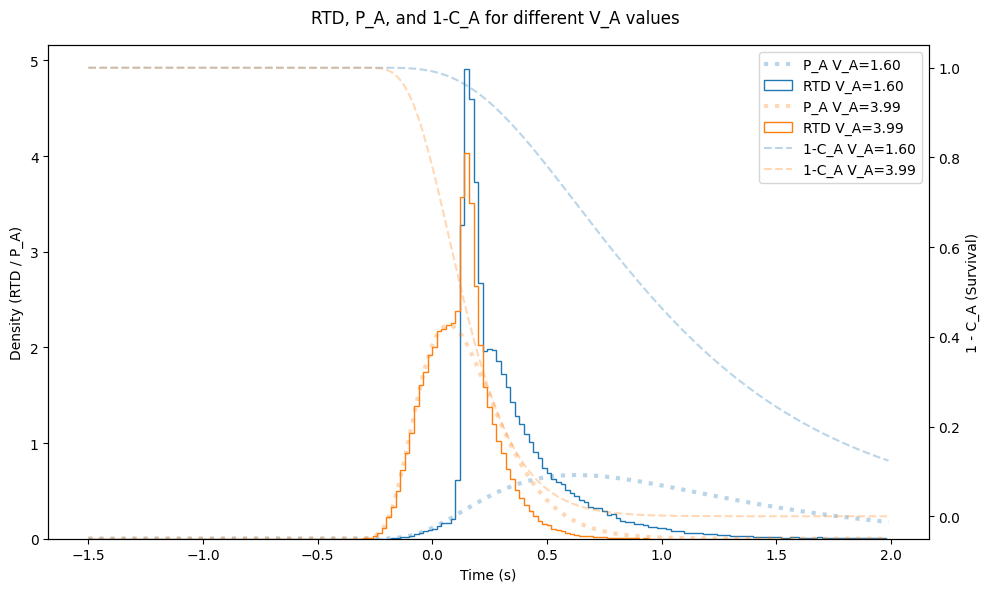

In [61]:
N_sim = int(1e5)
dt = 1e-3
V_A_samples = [V_A, 2.5 * V_A]

bins = np.arange(-1.5, 2, 0.02)
t_pts = np.arange(-1.5, 2, 0.01)

t_stim = 0.25

# For consistent colors
color_map = plt.cm.get_cmap('tab10')

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Secondary y-axis

for idx_va, V_A_sample in enumerate(V_A_samples):
    color = color_map(idx_va)

    # Theoretical part (P_A and C_A)
    P_A_mean = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A_sample, theta_A)
    C_A_mean_survive = 1 - cumtrapz(P_A_mean, t_pts, initial=0)

    # Simulations
    sim_results = Parallel(n_jobs=30)(
        delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
            V_A_sample, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E,
            t_A_aff, t_E_aff, del_go, t_stim, rate_norm_l, iter_num, N_print, 
            phi_params_obj, dt
        ) for iter_num in tqdm(range(N_sim), desc=f"Simulating for V_A={V_A_sample}")
    )

    df = pd.DataFrame(sim_results)
    rt_diffs = df['rt'] - df['t_stim']

    # Plot all 3 with same color, different style
    ax1.plot(t_pts, P_A_mean, ls=':', color=color, label=f'P_A V_A={V_A_sample:.2f}', lw=3, alpha=0.3)
    ax2.plot(t_pts, C_A_mean_survive, ls='--', color=color, label=f'1-C_A V_A={V_A_sample:.2f}', alpha=0.3)
    ax1.hist(rt_diffs, bins=bins, density=True, histtype='step', color=color, label=f'RTD V_A={V_A_sample:.2f}')

# Final plot setup
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Density (RTD / P_A)")
ax2.set_ylabel("1 - C_A (Survival)")

fig.suptitle("RTD, P_A, and 1-C_A for different V_A values")
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()


# check for RTD animal wise

In [39]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


In [40]:
df = df[~((df['abort_event'] == 3) & (df['timed_fix'] < 0.3))]


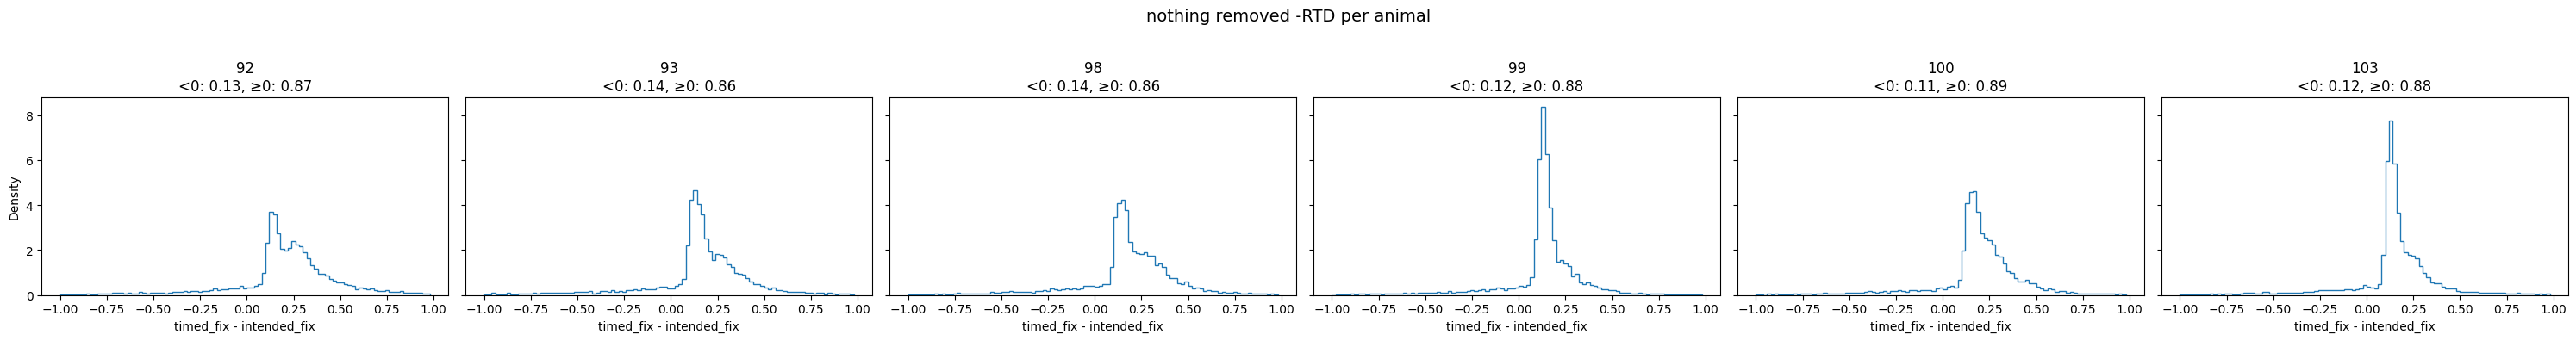

In [41]:
bins = np.arange(-1, 1, 0.02)
animals = df['animal'].unique()
n_animals = len(animals)

fig, axes = plt.subplots(1, n_animals, figsize=(5 * n_animals, 4), sharey=True)

for i, animal in enumerate(animals):
    ax = axes[i]
    subset = df[df['animal'] == animal]
    diff = subset['timed_fix'] - subset['intended_fix']
    
    # Histogram and density
    counts, edges = np.histogram(diff, bins=bins, density=True)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    bin_width = np.diff(edges)[0]

    # Area before and after 0
    area_before_0 = np.sum(counts[bin_centers < 0]) * bin_width
    area_after_0 = np.sum(counts[bin_centers >= 0]) * bin_width

    ax.hist(diff, bins=bins, density=True, histtype='step', label=f'{animal}')
    ax.set_xlabel("timed_fix - intended_fix")
    ax.set_title(f"{animal}\n<0: {area_before_0:.2f}, ≥0: {area_after_0:.2f}")

axes[0].set_ylabel("Density")
plt.suptitle("nothing removed -RTD per animal", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
